# Imports and Configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import pickle
import glob

warnings.filterwarnings('ignore')

In [2]:
SEED = 6
N_FOLDS = 5
TARGET = 'class'

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

X = train.drop(columns=[TARGET])
y = train[TARGET].map({'e': 0, 'p': 1})

In [4]:
def get_scores(oof_pred_probs):
    scores = []
    skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
        scores.append(score)
    return scores

# Loading OOF Predictions

In [5]:
test_pred_probs = {}
oof_pred_probs = {}
scores = {}

In [6]:
xgb_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-xgboost/xgb_oof_pred_probs_*.pkl')
xgb_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-xgboost/xgb_test_pred_probs_*.pkl')

xgb_oof_pred_probs = pickle.load(open(xgb_oof_pred_probs_files[0], 'rb'))
xgb_test_pred_probs = pickle.load(open(xgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
scores['XGBoost'] = get_scores(xgb_oof_pred_probs)

In [7]:
lgbm_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-lightgbm/lgbm_oof_pred_probs_*.pkl')
lgbm_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-lightgbm/lgbm_test_pred_probs_*.pkl')

lgbm_oof_pred_probs = pickle.load(open(lgbm_oof_pred_probs_files[0], 'rb'))
lgbm_test_pred_probs = pickle.load(open(lgbm_test_pred_probs_files[0], 'rb'))

oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
scores['LightGBM'] = get_scores(lgbm_oof_pred_probs)

In [8]:
histgb_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-histgb/histgradientboosting_oof_pred_probs_*.pkl')
histgb_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-histgb/histgradientboosting_test_pred_probs_*.pkl')

histgb_oof_pred_probs = pickle.load(open(histgb_oof_pred_probs_files[0], 'rb'))
histgb_test_pred_probs = pickle.load(open(histgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['HistGB'] = histgb_oof_pred_probs
test_pred_probs['HistGB'] = histgb_test_pred_probs
scores['HistGB'] = get_scores(histgb_oof_pred_probs)

# Optimizing Ensemble Weights

In [9]:
def objective(trial):
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 5.0)
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 5.0)
    histgb_weight = trial.suggest_float('histgb_weight', 0.0, 5.0)

    weights = [
        xgb_weight, 
        lgbm_weight, 
        histgb_weight, 
    ]
    weights /= np.sum(weights)

    pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
    for model, weight in zip(oof_pred_probs.keys(), weights):
        pred_probs += oof_pred_probs[model] * weight

    return matthews_corrcoef(y, np.argmax(pred_probs, axis=1))


sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['xgb', 'lgbm', 'histgb']]
best_weights /= np.sum(best_weights)

[I 2024-08-04 17:38:36,121] A new study created in memory with name: no-name-6687cbf8-6072-4da9-998f-73d0466f6dce
[I 2024-08-04 17:38:37,940] Trial 0 finished with value: 0.9848273646631271 and parameters: {'xgb_weight': 4.464300757180008, 'lgbm_weight': 1.6598990265058862, 'histgb_weight': 4.106145615289159}. Best is trial 0 with value: 0.9848273646631271.
[I 2024-08-04 17:38:39,759] Trial 1 finished with value: 0.984695502736001 and parameters: {'xgb_weight': 0.20848312862624951, 'lgbm_weight': 0.5382833996798397, 'histgb_weight': 2.975260321031201}. Best is trial 0 with value: 0.9848273646631271.
[I 2024-08-04 17:38:41,571] Trial 2 finished with value: 0.9848293633202375 and parameters: {'xgb_weight': 2.649086810964108, 'lgbm_weight': 2.0940371427832716, 'histgb_weight': 1.6770392463666461}. Best is trial 2 with value: 0.9848293633202375.
[I 2024-08-04 17:38:43,411] Trial 3 finished with value: 0.9848358224617306 and parameters: {'xgb_weight': 3.112597160980451, 'lgbm_weight': 2.190

In [10]:
print(best_weights)

[0.34873508 0.39033343 0.26093149]


# Ensembling OOF Predictions

In [11]:
ensemble_oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
for model, weight in zip(oof_pred_probs.keys(), best_weights):
    ensemble_oof_pred_probs += oof_pred_probs[model] * weight
    
ensemble_scores = matthews_corrcoef(y, np.argmax(ensemble_oof_pred_probs, axis=1))
scores['Ensemble'] = ensemble_scores

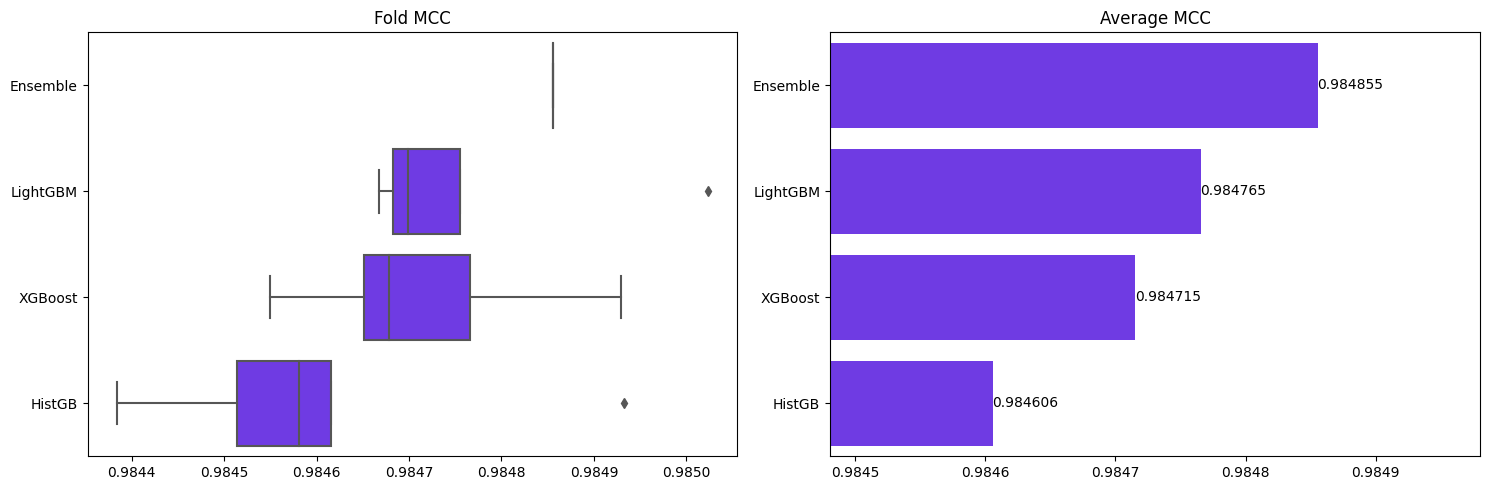

In [12]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold MCC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average MCC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

# Making Predictions

In [13]:
ensemble_test_pred_probs = np.zeros((test.shape[0], len(np.unique(y))))
for model, weight in zip(test_pred_probs.keys(), best_weights):
    ensemble_test_pred_probs += test_pred_probs[model] * weight

In [14]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
sub[TARGET] = np.argmax(ensemble_test_pred_probs, axis=1)
sub[TARGET] = sub[TARGET].map({0: 'e', 1: 'p'})
sub.to_csv(f'sub_ensemble_{np.mean(scores["Ensemble"]):.6f}.csv', index=False)
sub.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
